To a first approximation, the composite frequency spectrum provided by a LIBS gun is a weighted superposition of the single element spectra. The base assumption is that the weighting is proportional to their abundance in the sample. This notebook applies a straightforward least squares minimization to decompose a composite spectrum into the atomic composition.

Artifacts and noise can be added to the composite spectrum to explore the impact on fit vs. the "clean" spectrum. Various pre-processing steps could also be explored prior to the fit to see what types of noise filtering/cleaning might be effective.

The simplistic approach can serve as a benchmark for more complex approaches to spectral decomposition.

In [1]:
import pickle
import datetime
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from scipy.optimize import least_squares

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split

from libs_unet.models import peakyfinder_0001
from libs_unet.training.spec_maker import spectrum_maker

top_dir = Path.cwd()
datapath = top_dir / 'data'

/Users/matt/CloudGit_local/github/gss/phaseMAP/envs/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
#generate reference spectra
max_z = 30
wave = range(190, 950)
elem_symb = np.loadtxt(datapath / "abundance/elements_94.csv", dtype=str)
spec_maker = spectrum_maker(max_z)

#create array of reference spectra for these 20 elements.
el_spec = np.zeros((max_z,len(wave)))
for i in range(max_z):
    i_fracs = np.zeros(max_z)
    i_fracs[i] = 1
    wave, el_spec[i], spec_array = spec_maker.make_spectra(i_fracs)
    


sum for Li is 1.0


<function matplotlib.pyplot.show(close=None, block=None)>

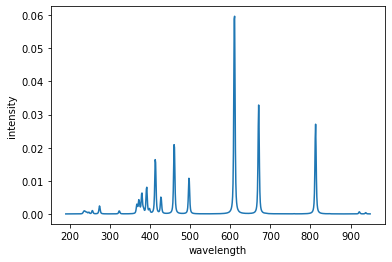

In [5]:
#check spectra
z_el = 3
print(f"sum for {elem_symb[z_el -1]} is {np.sum(el_spec[z_el -1])}")
plt.plot(wave, el_spec[z_el -1])
plt.xlabel('wavelength')
plt.ylabel('intensity')
plt.show

In [6]:
#next task is to find the linear combination of the atomic spectra that minimizes error to input spectrum
#Try https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html

#define the residuals function
def fun_fitspec(x, x_spec, ref_specs):
    return np.squeeze(np.sum((ref_specs.transpose() * x).transpose(), axis=0) - x_spec)

#weight bounds passed as a 2-tuple of vectors ([lower], [upper]) use np.inf for unbounded
#lower bound for all is non-negative weights
bnd_low = np.zeros(max_z)
#upper bound is 1 (pure). must include small delta to zero to exclude, e.g. 0.0001
bnd_up = np.ones(max_z)
el_bounds = (bnd_low, bnd_up)
#Initial guess at weights is even allocation
x0 = np.ones(max_z) * (1/max_z)
#use the following form to run the LS min for a given input_spec of shape 
#el_fit = least_squares(fun_fitspec, x0, args=(input_spec, el_spec), bounds=el_bounds)

In [9]:
#Test arbitrary mixture of elements
#test_fracs = np.zeros(20)
test_fracs = np.ones(max_z) / max_z
#generate input spectrum
wave, test_spec, spec_array = spec_maker.make_spectra(test_fracs)
test_fit = least_squares(fun_fitspec, x0, args=(test_spec, el_spec), bounds=el_bounds)

In [11]:
#review results
#library does not allow linear constraints so cannot constrain sum of x <=1
fit_wts = test_fit.x.copy()
fit_wts[fit_wts < 0.01] = 0
fit_wts = fit_wts / np.sum(fit_wts)

for i in range(len(fit_wts)):
    print(f"{elem_symb[i]}: ref: {np.round(test_fracs[i],3)} pred: {np.round(fit_wts[i],3)}")


H: ref: 0.033 pred: 0.035
He: ref: 0.033 pred: 0.037
Li: ref: 0.033 pred: 0.04
Be: ref: 0.033 pred: 0.035
B: ref: 0.033 pred: 0.033
C: ref: 0.033 pred: 0.038
N: ref: 0.033 pred: 0.023
O: ref: 0.033 pred: 0.034
F: ref: 0.033 pred: 0.031
Ne: ref: 0.033 pred: 0.035
Na: ref: 0.033 pred: 0.033
Mg: ref: 0.033 pred: 0.031
Al: ref: 0.033 pred: 0.026
Si: ref: 0.033 pred: 0.04
P: ref: 0.033 pred: 0.015
S: ref: 0.033 pred: 0.04
Cl: ref: 0.033 pred: 0.035
Ar: ref: 0.033 pred: 0.033
K: ref: 0.033 pred: 0.033
Ca: ref: 0.033 pred: 0.036
Sc: ref: 0.033 pred: 0.026
Ti: ref: 0.033 pred: 0.038
V: ref: 0.033 pred: 0.031
Cr: ref: 0.033 pred: 0.024
Mn: ref: 0.033 pred: 0.036
Fe: ref: 0.033 pred: 0.053
Co: ref: 0.033 pred: 0.032
Ni: ref: 0.033 pred: 0.027
Cu: ref: 0.033 pred: 0.035
Zn: ref: 0.033 pred: 0.035


In [109]:
#notes on element-wise array multiplication
x = np.array([1,2,3])
y = np.array(np.ones(12))
y = y.reshape(3,4)
print(x.shape)
print(y.transpose().shape)
print(y)
print(y.transpose())
print((y.transpose()*x).transpose()) #element-wise but need dims to align

(3,)
(4, 3)
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[[1. 1. 1. 1.]
 [2. 2. 2. 2.]
 [3. 3. 3. 3.]]
